<a href="https://www.kaggle.com/code/leoelieson/sropmnist?scriptVersionId=235566531" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://colab.research.google.com/github/ClemButterscotch/SROP/blob/main/SROP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import struct
from scipy.stats import mode
import gzip

import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Subset
from torchsummary import summary

from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [3]:
import kagglehub

mnist_dataset_path = kagglehub.dataset_download('zalando-research/fashionmnist')

In [4]:
import os, struct, gzip, numpy as np

def _smart_open(path):
    # transparently handle .gz files
    return gzip.open(path, 'rb') if path.endswith('.gz') else open(path, 'rb')

def find_file(base_path, fname):
    """Return the real file, no matter how Kaggle wrapped it."""
    direct = os.path.join(base_path, fname)                 # /…/fname
    wrapped = os.path.join(base_path, fname, fname)         # /…/fname/fname
    for p in (direct, direct + '.gz', wrapped, wrapped + '.gz'):
        if os.path.isfile(p):
            return p
    raise FileNotFoundError(f'{fname} not found under {base_path}')

def load_images(path):
    with _smart_open(path) as f:
        magic, size = struct.unpack(">II", f.read(8))
        rows, cols  = struct.unpack(">II", f.read(8))
        data = np.frombuffer(f.read(rows * cols * size), dtype=np.uint8)
        return data.reshape(size, rows * cols)

def load_labels(path):
    with _smart_open(path) as f:
        _, size = struct.unpack(">II", f.read(8))
        return np.frombuffer(f.read(size), dtype=np.uint8)

def load_mnist_data(base_path):
    X_train = load_images(find_file(base_path, 'train-images-idx3-ubyte'))
    y_train = load_labels(find_file(base_path, 'train-labels-idx1-ubyte'))
    X_test  = load_images(find_file(base_path, 't10k-images-idx3-ubyte'))
    y_test  = load_labels(find_file(base_path, 't10k-labels-idx1-ubyte'))
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_mnist_data(mnist_dataset_path)
print(X_train.shape, y_train.shape)   # (60000, 784) (60000,)

(60000, 784) (60000,)


(60000, 784)


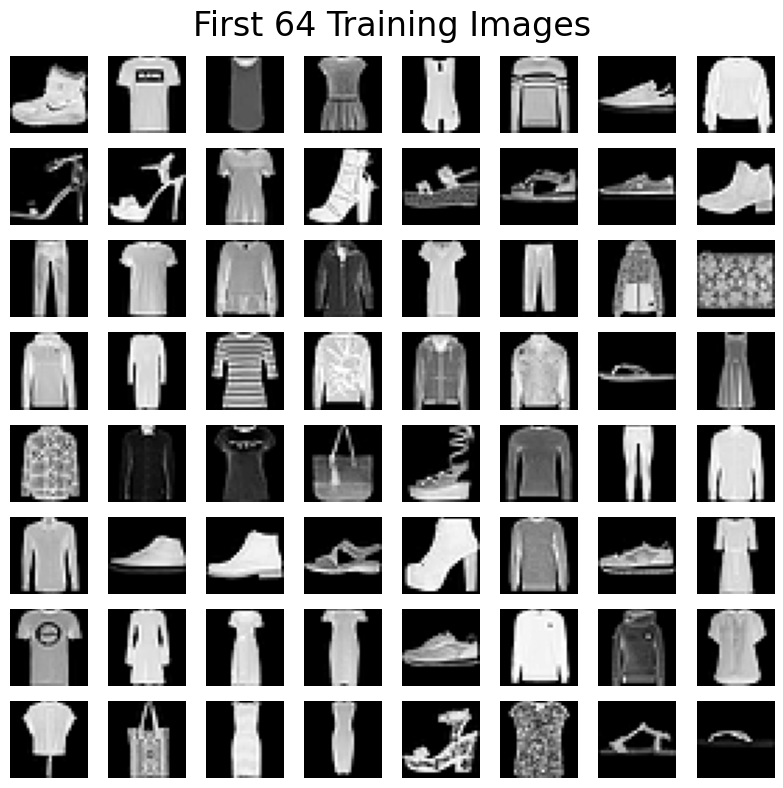

In [5]:
def plot_digits(X, n=8, title="First 64 Training Images"):
    """
    Show the first n×n images in a grid.

    Parameters
    ----------
    X : arraylike, shape (n_samples, 784)
        Each row is a 28×28 image flattened to length 784.
    n : int, optional
        Grid size (default = 8 gives 64 images).
    title : str
        Figure title.
    """
    fig, axes = plt.subplots(n, n, figsize=(8, 8))
    axes = axes.flatten()

    for img, ax in zip(X[: n * n], axes):
        ax.imshow(img.reshape(28, 28), cmap="gray")
        ax.axis("off")

    fig.suptitle(title, fontsize=24)
    plt.tight_layout()
    plt.show()


print(X_train.shape)        # (60000, 784)
plot_digits(X_train, 8, "First 64 Training Images")

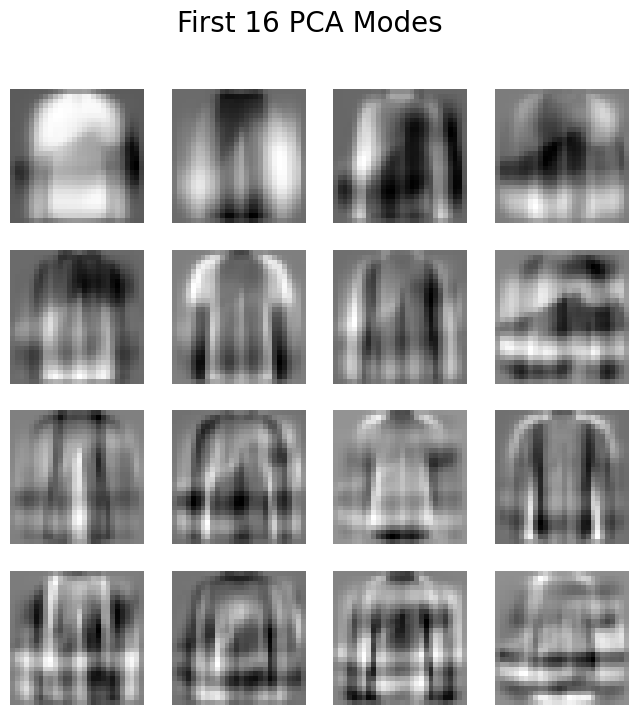

In [6]:
pca = PCA()
pca.fit(X_train)
pc_modes = pca.components_[:16]

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i in range(4):
    for j in range(4):
        idx = i * 4 + j
        axs[i, j].imshow(pc_modes[idx].reshape(28, 28), cmap="gray")
        axs[i, j].axis("off")
fig.suptitle("First 16 PCA Modes", fontsize=20)
plt.show()

In [7]:
Sigma = pca.singular_values_

energy = np.power(Sigma, 2) / np.sum(np.power(Sigma, 2))
cumulative_energy = np.cumsum(energy)
k = np.argmax(cumulative_energy >= 0.85) + 1

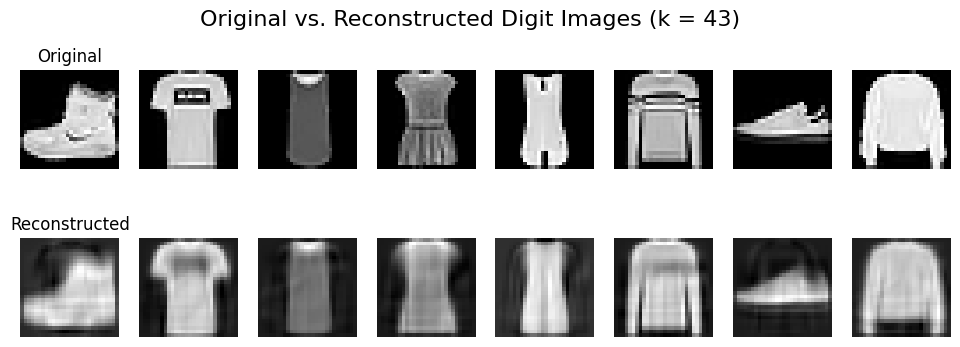

In [8]:
pca_k = PCA(n_components=k)
Xtrain_reduced = pca_k.fit_transform(X_train)
Xtrain_reconstructed = pca_k.inverse_transform(Xtrain_reduced)

num_images = 8
fig, axs = plt.subplots(2, num_images, figsize=(num_images * 1.5, 4))
for i in range(num_images):
    axs[0, i].imshow(X_train[i].reshape(28, 28), cmap="gray")
    axs[0, i].axis("off")
    if i == 0:
        axs[0, i].set_title("Original", fontsize=12)
    # Reconstruction below
    axs[1, i].imshow(Xtrain_reconstructed[i].reshape(28, 28), cmap="gray")
    axs[1, i].axis("off")
    if i == 0:
        axs[1, i].set_title("Reconstructed", fontsize=12)

fig.suptitle("Original vs. Reconstructed Digit Images (k = {})".format(k), fontsize=16)
plt.show()


In [9]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

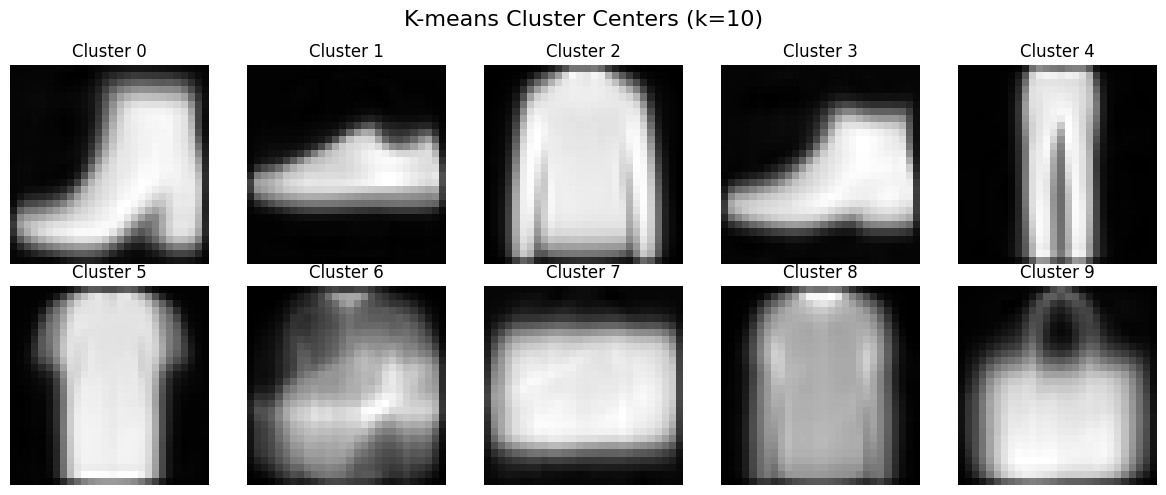

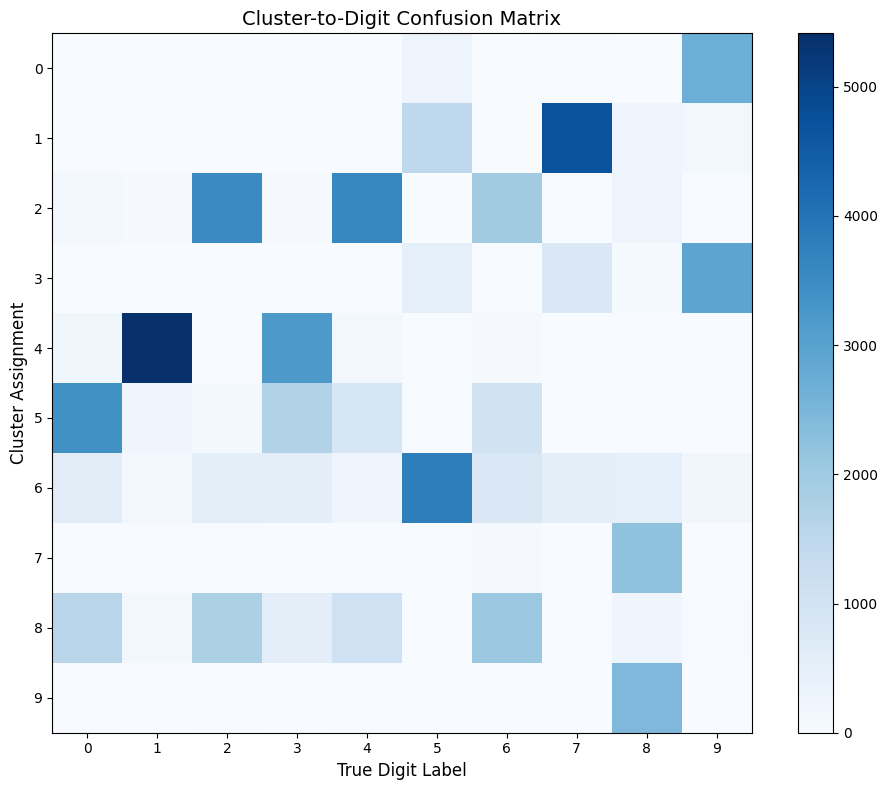

K-means clustering accuracy: 0.553


In [10]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm

# Apply K-means on PCA-reduced data
n_clusters = 10  # Since we have 10 digits/classes
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_train)

# Visualize cluster centers as images
centers = kmeans.cluster_centers_
# Project the cluster centers through PCA for better visualization
# First transform centers to PCA space, then back to image space
centers_pca = pca_k.transform(centers)
reconstructed_centers = pca_k.inverse_transform(centers_pca)

# Plot the reconstructed cluster centers
plt.figure(figsize=(12, 5))
for i in range(n_clusters):
    plt.subplot(2, 5, i+1)
    plt.imshow(reconstructed_centers[i].reshape(28, 28), cmap="gray")
    plt.title(f'Cluster {i}')
    plt.axis('off')
plt.suptitle('K-means Cluster Centers (k=10)', fontsize=16)
plt.tight_layout()
plt.show()

# Evaluate clusters by comparing with true labels
from scipy.stats import mode

# For each cluster, find the most common digit
clusters_to_digits = {}
for i in range(n_clusters):
    mask = (cluster_labels == i)
    cluster_labels_true = y_train[mask]
    if len(cluster_labels_true) > 0:
        mode_result = mode(cluster_labels_true)
        # Handle both array and scalar cases
        if hasattr(mode_result[0], '__iter__'):
            most_common = mode_result[0][0]
        else:
            most_common = mode_result[0]
        clusters_to_digits[i] = most_common

# Create a confusion matrix between clusters and true labels
cluster_confusion = np.zeros((n_clusters, 10), dtype=int)
for i, true_label in enumerate(y_train):
    cluster = cluster_labels[i]
    cluster_confusion[cluster, true_label] += 1

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cluster_confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Cluster-to-Digit Confusion Matrix', fontsize=14)
plt.colorbar()
plt.xlabel('True Digit Label', fontsize=12)
plt.ylabel('Cluster Assignment', fontsize=12)
plt.xticks(range(10))
plt.yticks(range(n_clusters))
plt.tight_layout()
plt.show()

# Calculate clustering accuracy (using the most common digit in each cluster)
correct = 0
for i, label in enumerate(y_train):
    cluster = cluster_labels[i]
    if clusters_to_digits.get(cluster) == label:
        correct += 1
clustering_accuracy = correct / len(y_train)
print(f"K-means clustering accuracy: {clustering_accuracy:.3f}")

Ridge (Multi-class) - CV Accuracy: 0.783, Test Accuracy: 0.773
KNN (Multi-class) - CV Accuracy: 0.856, Test Accuracy: 0.857


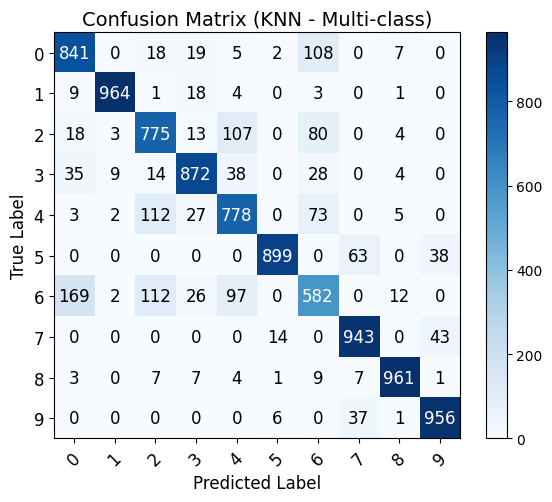

In [11]:
Xtrain_pca = pca_k.transform(X_train)
Xtest_pca = pca_k.transform(X_test)

# Ridge Classifier (Multi-class)!!
ridge = RidgeClassifier()
ridge_cv = cross_val_score(ridge, Xtrain_pca, y_train, cv=5)
ridge.fit(Xtrain_pca, y_train)
ridge_acc = ridge.score(Xtest_pca, y_test)
print(f"Ridge (Multi-class) - CV Accuracy: {ridge_cv.mean():.3f}, Test Accuracy: {ridge_acc:.3f}")

# KNN Classifier (Multi-class)!!
knn = KNeighborsClassifier(n_neighbors=5)
knn_cv = cross_val_score(knn, Xtrain_pca, y_train, cv=5)
knn.fit(Xtrain_pca, y_train)
knn_acc = knn.score(Xtest_pca, y_test)
print(f"KNN (Multi-class) - CV Accuracy: {knn_cv.mean():.3f}, Test Accuracy: {knn_acc:.3f}")
# Taken from scikit learn documentation
y_pred_knn = knn.predict(Xtest_pca)
cm_multi = confusion_matrix(y_test, y_pred_knn)
classes = np.unique(y_test)
plot_confusion_matrix(cm_multi, classes=classes, title='Confusion Matrix (KNN - Multi-class)')

In [12]:
print(f"Ridge Classifier:      {ridge_acc:.3f}")
print(f"KNN Classifier (k=5):  {knn_acc:.3f}")

Ridge Classifier:      0.773
KNN Classifier (k=5):  0.857


In [13]:
import csv

data = [
    ["Algorithm","Test Accuracy"],
    ["k-means",0.553],
    ["Ridge",0.773],
    ["KNN",0.857]
]

csv_file_path = 'Fashion-MNIST.csv'

# Open the file in write mode
with open(csv_file_path, mode='w', newline='') as file:
    # Create a csv.writer object
    writer = csv.writer(file)
    # Write data to the CSV file
    writer.writerows(data)

# Print a confirmation message
print(f"CSV file '{csv_file_path}' created successfully.")

CSV file 'Fashion-MNIST.csv' created successfully.
